In [67]:
import os
import sys
import re
from typing import Optional, List, Literal

while any(marker in os.getcwd() for marker in ['workspace']):
    os.chdir("..")

sys.path.append('classes_and_functions')

current_directory = os.getcwd()
current_directory


'c:\\Users\\maria\\OneDrive\\Desktop\\ML'

In [68]:
pip install imblearn

Note: you may need to restart the kernel to use updated packages.


In [69]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler, MinMaxScaler, OrdinalEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, precision_score, accuracy_score, make_scorer, recall_score, f1_score, confusion_matrix
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBClassifier
from sklearn.metrics import make_scorer, mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import LinearSVR
from sklearn.kernel_approximation import Nystroem
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

from custom_functions_classes import CustomOutlierDetector

In [70]:
class CustomEvaluator:
    def __init__(self, model, k_count=5):
        self.model = model
        self.k_count = k_count
        self.report = None

    def evaluate(self, resampled_data):
        all_reports = []
        conf_matrices = []

        column_mapping = {
            "0.0": 'clear',
            "1.0": 'donbot',
            "2.0": 'fast_flux',
            "3.0": 'neris',
            "4.0": 'qvod',
            "5.0": 'rbot'
        }

        for _, (X_res, y_res, X_val, y_val) in resampled_data.items():
            self.model.fit(X_res, y_res)
            y_pred = self.model.predict(X_val)
            report_dict = classification_report(y_val, y_pred, output_dict=True)
            all_reports.append(report_dict)

            conf_matrices.append(confusion_matrix(y_val, y_pred))

        metrics = ['precision', 'recall', 'f1-score']
        avg_results = {
            metric: {
                cls: np.nanmean([fold.get(cls, {}).get(metric, np.nan) for fold in all_reports])
                for cls in column_mapping.keys()
            }
            for metric in metrics
        }

        # Calculate overall accuracy (across all folds)
        avg_accuracy = np.mean([fold.get('accuracy', np.nan) for fold in all_reports])

        # dictionary for the results
        metrics_dict = {
            "Precision": [avg_results['precision'].get(cls, np.nan) for cls in column_mapping.keys()] + [avg_accuracy],
            "Recall": [avg_results['recall'].get(cls, np.nan) for cls in column_mapping.keys()] + [avg_accuracy],
            "F1-score": [avg_results['f1-score'].get(cls, np.nan) for cls in column_mapping.keys()] + [avg_accuracy],
            "Overall Accuracy": [avg_accuracy] * len(column_mapping) + [avg_accuracy]  # Ensure "Overall Accuracy" is aligned
        }

        metrics_df = pd.DataFrame(metrics_dict, index=list(column_mapping.values()) + ["Overall"])
        aggregated_conf_matrix = np.sum(conf_matrices, axis=0)
        self.report = metrics_df
        return metrics_df, aggregated_conf_matrix


In [71]:
class DropColumns(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.drop(columns=self.columns)
    

class BinaryTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        for col in self.columns:
            X[col] = X[col].apply(lambda x: 1 if x == "True" else 0)
        return X


def create_pipeline(drop_columns, binary_columns):
    pipeline = Pipeline([
        ('drop_columns', DropColumns(columns=drop_columns)),
        ('binary_transform', BinaryTransformer(columns=binary_columns)),
        ('encoder', ColumnTransformer([
            ('dst_ip', OrdinalEncoder(), ["DST_IP"]),
            ('src_ip', OrdinalEncoder(), ["SRC_IP"])
        ], remainder='passthrough')),
        ('imputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
        ('scaler', MinMaxScaler()),
        ('pca', PCA(n_components=0.99))
    ])
    return pipeline

In [72]:
raw_data = pd.read_csv('Data_set_task_3.csv')
raw_data.head()


,Unnamed: 0.1,Unnamed: 0,DST_IP,SRC_IP,PACKETS,PACKETS_REV,BYTES,BYTES_REV,TIME_FIRST,TIME_LAST,...,SPECTRAL_SKEWNESS,SPECTRAL_ROLLOFF,SPECTRAL_CENTROID,SPECTRAL_SPREAD,SPECTRAL_SLOPE,SPECTRAL_CREST,SPECTRAL_FLUX,SPECTRAL_BANDWIDTH,PERIODICITY_SCDF,LABEL
0,0,0,147.32.80.9,147.32.84.165,4,2,134,558,1.312967e+09,1.312967e+09,...,207900.070205,0.885171,0.205123,0.417904,NaN,4248.583372,4544.559854,0.564213,0.003325,neris
1,1,1,147.32.84.255,147.32.84.165,38,0,2476,0,1.312967e+09,1.312967e+09,...,5314.872532,0.038851,0.241710,0.223803,-1.333903,3.640725,0.786195,-0.830029,0.046606,clear
2,2,2,147.32.84.255,147.32.84.165,6,0,1160,0,1.312967e+09,1.312967e+09,...,-271216.457937,0.010243,0.393857,0.271931,NaN,214.629001,1171.605316,-0.489713,0.011965,clear
3,3,3,147.32.84.165.,60.190.222.139,4,0,249,0,1.312967e+09,1.312967e+09,...,-1060.499747,0.006667,0.407122,0.273574,-0.362061,1.505125,2.539462,-0.400313,0.010620,clear
4,4,4,60.190.222.139.,147.32.84.165,10,0,138,0,1.312967e+09,1.312967e+09,...,-4837.676869,0.187056,0.482592,0.285750,-0.098411,1.314013,2.857491,0.565604,0.021624,clear


In [73]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 176640 entries, 0 to 176639
Data columns (total 85 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Unnamed: 0.1                176640 non-null  int64  
 1   Unnamed: 0                  176640 non-null  int64  
 2   DST_IP                      176640 non-null  object 
 3   SRC_IP                      176640 non-null  object 
 4   PACKETS                     176640 non-null  int64  
 5   PACKETS_REV                 176640 non-null  int64  
 6   BYTES                       176640 non-null  int64  
 7   BYTES_REV                   176640 non-null  int64  
 8   TIME_FIRST                  176640 non-null  float64
 9   TIME_LAST                   176640 non-null  float64
 10  DST_PORT                    176640 non-null  int64  
 11  SRC_PORT                    176640 non-null  int64  
 12  MEAN                        176640 non-null  int64  
 13  MEDIAN        

In [74]:
raw_data.describe()

,Unnamed: 0.1,Unnamed: 0,PACKETS,PACKETS_REV,BYTES,BYTES_REV,TIME_FIRST,TIME_LAST,DST_PORT,SRC_PORT,...,SPECTRAL_KURTOSIS,SPECTRAL_SKEWNESS,SPECTRAL_ROLLOFF,SPECTRAL_CENTROID,SPECTRAL_SPREAD,SPECTRAL_SLOPE,SPECTRAL_CREST,SPECTRAL_FLUX,SPECTRAL_BANDWIDTH,PERIODICITY_SCDF
count,176640.000000,176640.000000,176640.000000,176640.000000,1.766400e+05,176640.000000,1.766400e+05,1.766400e+05,176640.000000,176640.000000,...,4.312100e+04,43121.000000,176640.000000,39334.000000,36059.000000,26100.000000,4.312100e+04,4.312100e+04,176640.000000,4.312100e+04
mean,21168.632971,21168.632971,9.419888,0.217771,2.709868e+03,44.503872,1.313300e+09,1.313300e+09,2999.505480,4250.088111,...,5.366581e+06,1288.679880,0.066117,0.531804,0.274129,-0.020180,-4.040107e+02,4.960171e+11,0.001087,2.961745e-01
std,16541.011330,16541.011330,169.797195,4.108624,2.510049e+05,703.591065,1.915764e+05,1.915729e+05,8024.511061,7951.819407,...,8.263482e+06,141888.336488,0.186869,4.480683,0.042967,0.346216,4.303365e+04,7.221156e+13,0.304518,3.558592e-01
min,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,1.312967e+09,1.312967e+09,0.000000,21.000000,...,5.956974e+03,-353447.270758,0.006667,-284.708880,0.000233,-4.374491,-3.911477e+06,1.197955e-05,-0.993135,2.220446e-16
25%,7461.750000,7461.750000,3.000000,0.000000,0.000000e+00,0.000000,1.313059e+09,1.313059e+09,25.000000,1042.000000,...,1.214269e+04,-4702.869615,0.006667,0.465382,0.269788,-0.125575,1.030636e+00,2.720182e-01,0.000000,3.168378e-02
50%,17461.000000,17461.000000,6.000000,0.000000,0.000000e+00,0.000000,1.313384e+09,1.313384e+09,135.000000,2343.000000,...,2.327382e+04,1803.926840,0.006667,0.504215,0.284076,0.000587,1.725682e+00,2.726630e+00,0.000000,1.228350e-01
75%,31998.000000,31998.000000,6.000000,0.000000,2.500000e+01,0.000000,1.313452e+09,1.313452e+09,2578.000000,4052.000000,...,9.884095e+06,8205.515912,0.006667,0.543769,0.287304,0.112778,4.859257e+00,7.922754e+01,0.000000,4.489483e-01
max,63913.000000,63913.000000,37770.000000,697.000000,5.648519e+07,58896.000000,1.313567e+09,1.313567e+09,65520.000000,65520.000000,...,2.499000e+07,353447.266462,0.999801,451.937436,3.389829,2.221562,1.386986e+06,1.140911e+16,0.993135,1.000000e+00


In [75]:
def unique_column_content(df):
    for column in df.columns:
        if (df[column].dtype == 'object') or (df[column].dtype == 'str'):  # Check if the column is categorical
            unique_values = df[column].unique()
            print(f"{column}: {unique_values}\nLength: {len(unique_values)}\n")

unique_column_content(raw_data)

DST_IP: ['147.32.80.9' '147.32.84.255' '147.32.84.165.' ... '147.32.83.182.'
 '64.142.97.114.' '95.130.170.231.']
Length: 36781

SRC_IP: ['147.32.84.165' '60.190.222.139' '212.117.171.138' ... '147.32.84.118'
 '64.142.97.114' '95.130.170.231']
Length: 5145

LABEL: ['neris' 'clear' 'rbot' 'fast_flux' 'donbot' 'qvod']
Length: 6



Checking distribution of the target variable

In [76]:
count_target = raw_data['LABEL'].value_counts()
count_target

LABEL
clear        165573
neris          6332
fast_flux      4367
qvod            286
rbot             55
donbot           27
Name: count, dtype: int64

C:\Users\maria\AppData\Local\Temp\ipykernel_20380\2369614767.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=count_target.index, y=count_target.values, palette='viridis')


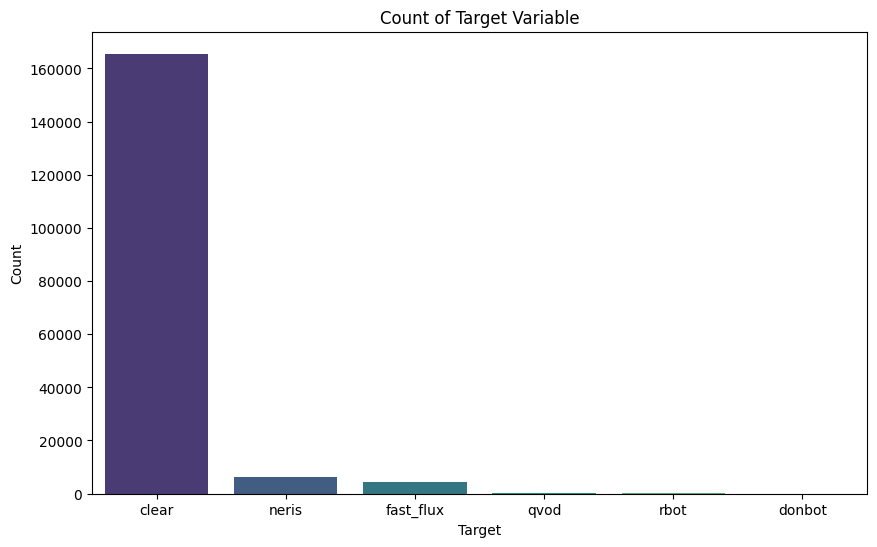

In [77]:
plt.figure(figsize=(10, 6))
sns.barplot(x=count_target.index, y=count_target.values, palette='viridis')
plt.title('Count of Target Variable')
plt.xlabel('Target')
plt.ylabel('Count')
plt.show()

Checking correlation

In [78]:
numeric_data = raw_data.select_dtypes(include=[np.number])
correlation_matrix = numeric_data.corr()
correlation_matrix

,Unnamed: 0.1,Unnamed: 0,PACKETS,PACKETS_REV,BYTES,BYTES_REV,TIME_FIRST,TIME_LAST,DST_PORT,SRC_PORT,...,SPECTRAL_KURTOSIS,SPECTRAL_SKEWNESS,SPECTRAL_ROLLOFF,SPECTRAL_CENTROID,SPECTRAL_SPREAD,SPECTRAL_SLOPE,SPECTRAL_CREST,SPECTRAL_FLUX,SPECTRAL_BANDWIDTH,PERIODICITY_SCDF
Unnamed: 0.1,1.000000,1.000000,-0.017364,-0.050632,-0.007857,-0.060119,0.362223,0.362215,0.175285,-0.021194,...,-0.042699,-0.016296,-0.108421,-0.002707,0.022009,0.096321,0.005168,-0.004934,0.071842,-0.046200
Unnamed: 0,1.000000,1.000000,-0.017364,-0.050632,-0.007857,-0.060119,0.362223,0.362215,0.175285,-0.021194,...,-0.042699,-0.016296,-0.108421,-0.002707,0.022009,0.096321,0.005168,-0.004934,0.071842,-0.046200
PACKETS,-0.017364,-0.017364,1.000000,0.045985,0.988998,0.031765,-0.005487,-0.005470,0.019951,0.006137,...,-0.035255,0.001878,0.021083,-0.000811,0.001761,-0.030469,0.000501,-0.000450,-0.021255,0.011232
PACKETS_REV,-0.050632,-0.050632,0.045985,1.000000,0.000730,0.702571,-0.050001,-0.049969,-0.014411,-0.000141,...,-0.045045,0.005321,0.096174,0.000814,-0.018472,0.065989,0.000501,0.000083,0.019931,0.032563
BYTES,-0.007857,-0.007857,0.988998,0.000730,1.000000,0.001036,0.002675,0.002683,0.010038,-0.001464,...,-0.012429,0.000715,0.003466,-0.000350,0.000711,-0.014843,0.000188,-0.000149,-0.008192,0.012494
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SPECTRAL_SLOPE,0.096321,0.096321,-0.030469,0.065989,-0.014843,0.076755,-0.045702,-0.045663,-0.129982,0.108321,...,-0.037667,-0.088790,0.484735,0.943823,0.126488,1.000000,-0.305489,-0.091084,0.550646,0.049073
SPECTRAL_CREST,0.005168,0.005168,0.000501,0.000501,0.000188,0.000343,-0.009265,-0.009264,0.003301,0.004114,...,0.000770,0.016628,-0.000565,-0.820761,0.370098,-0.305489,1.000000,0.000257,-0.000112,0.004408
SPECTRAL_FLUX,-0.004934,-0.004934,-0.000450,0.000083,-0.000149,-0.000707,-0.000631,-0.000632,-0.001863,-0.001869,...,0.008858,-0.002111,-0.005337,-0.000604,-0.033571,-0.091084,0.000257,1.000000,0.005853,-0.005717
SPECTRAL_BANDWIDTH,0.071842,0.071842,-0.021255,0.019931,-0.008192,0.021594,-0.003329,-0.003323,-0.020738,0.058122,...,-0.005903,-0.000898,0.399339,0.006469,0.041001,0.550646,-0.000112,0.005853,1.000000,-0.147859


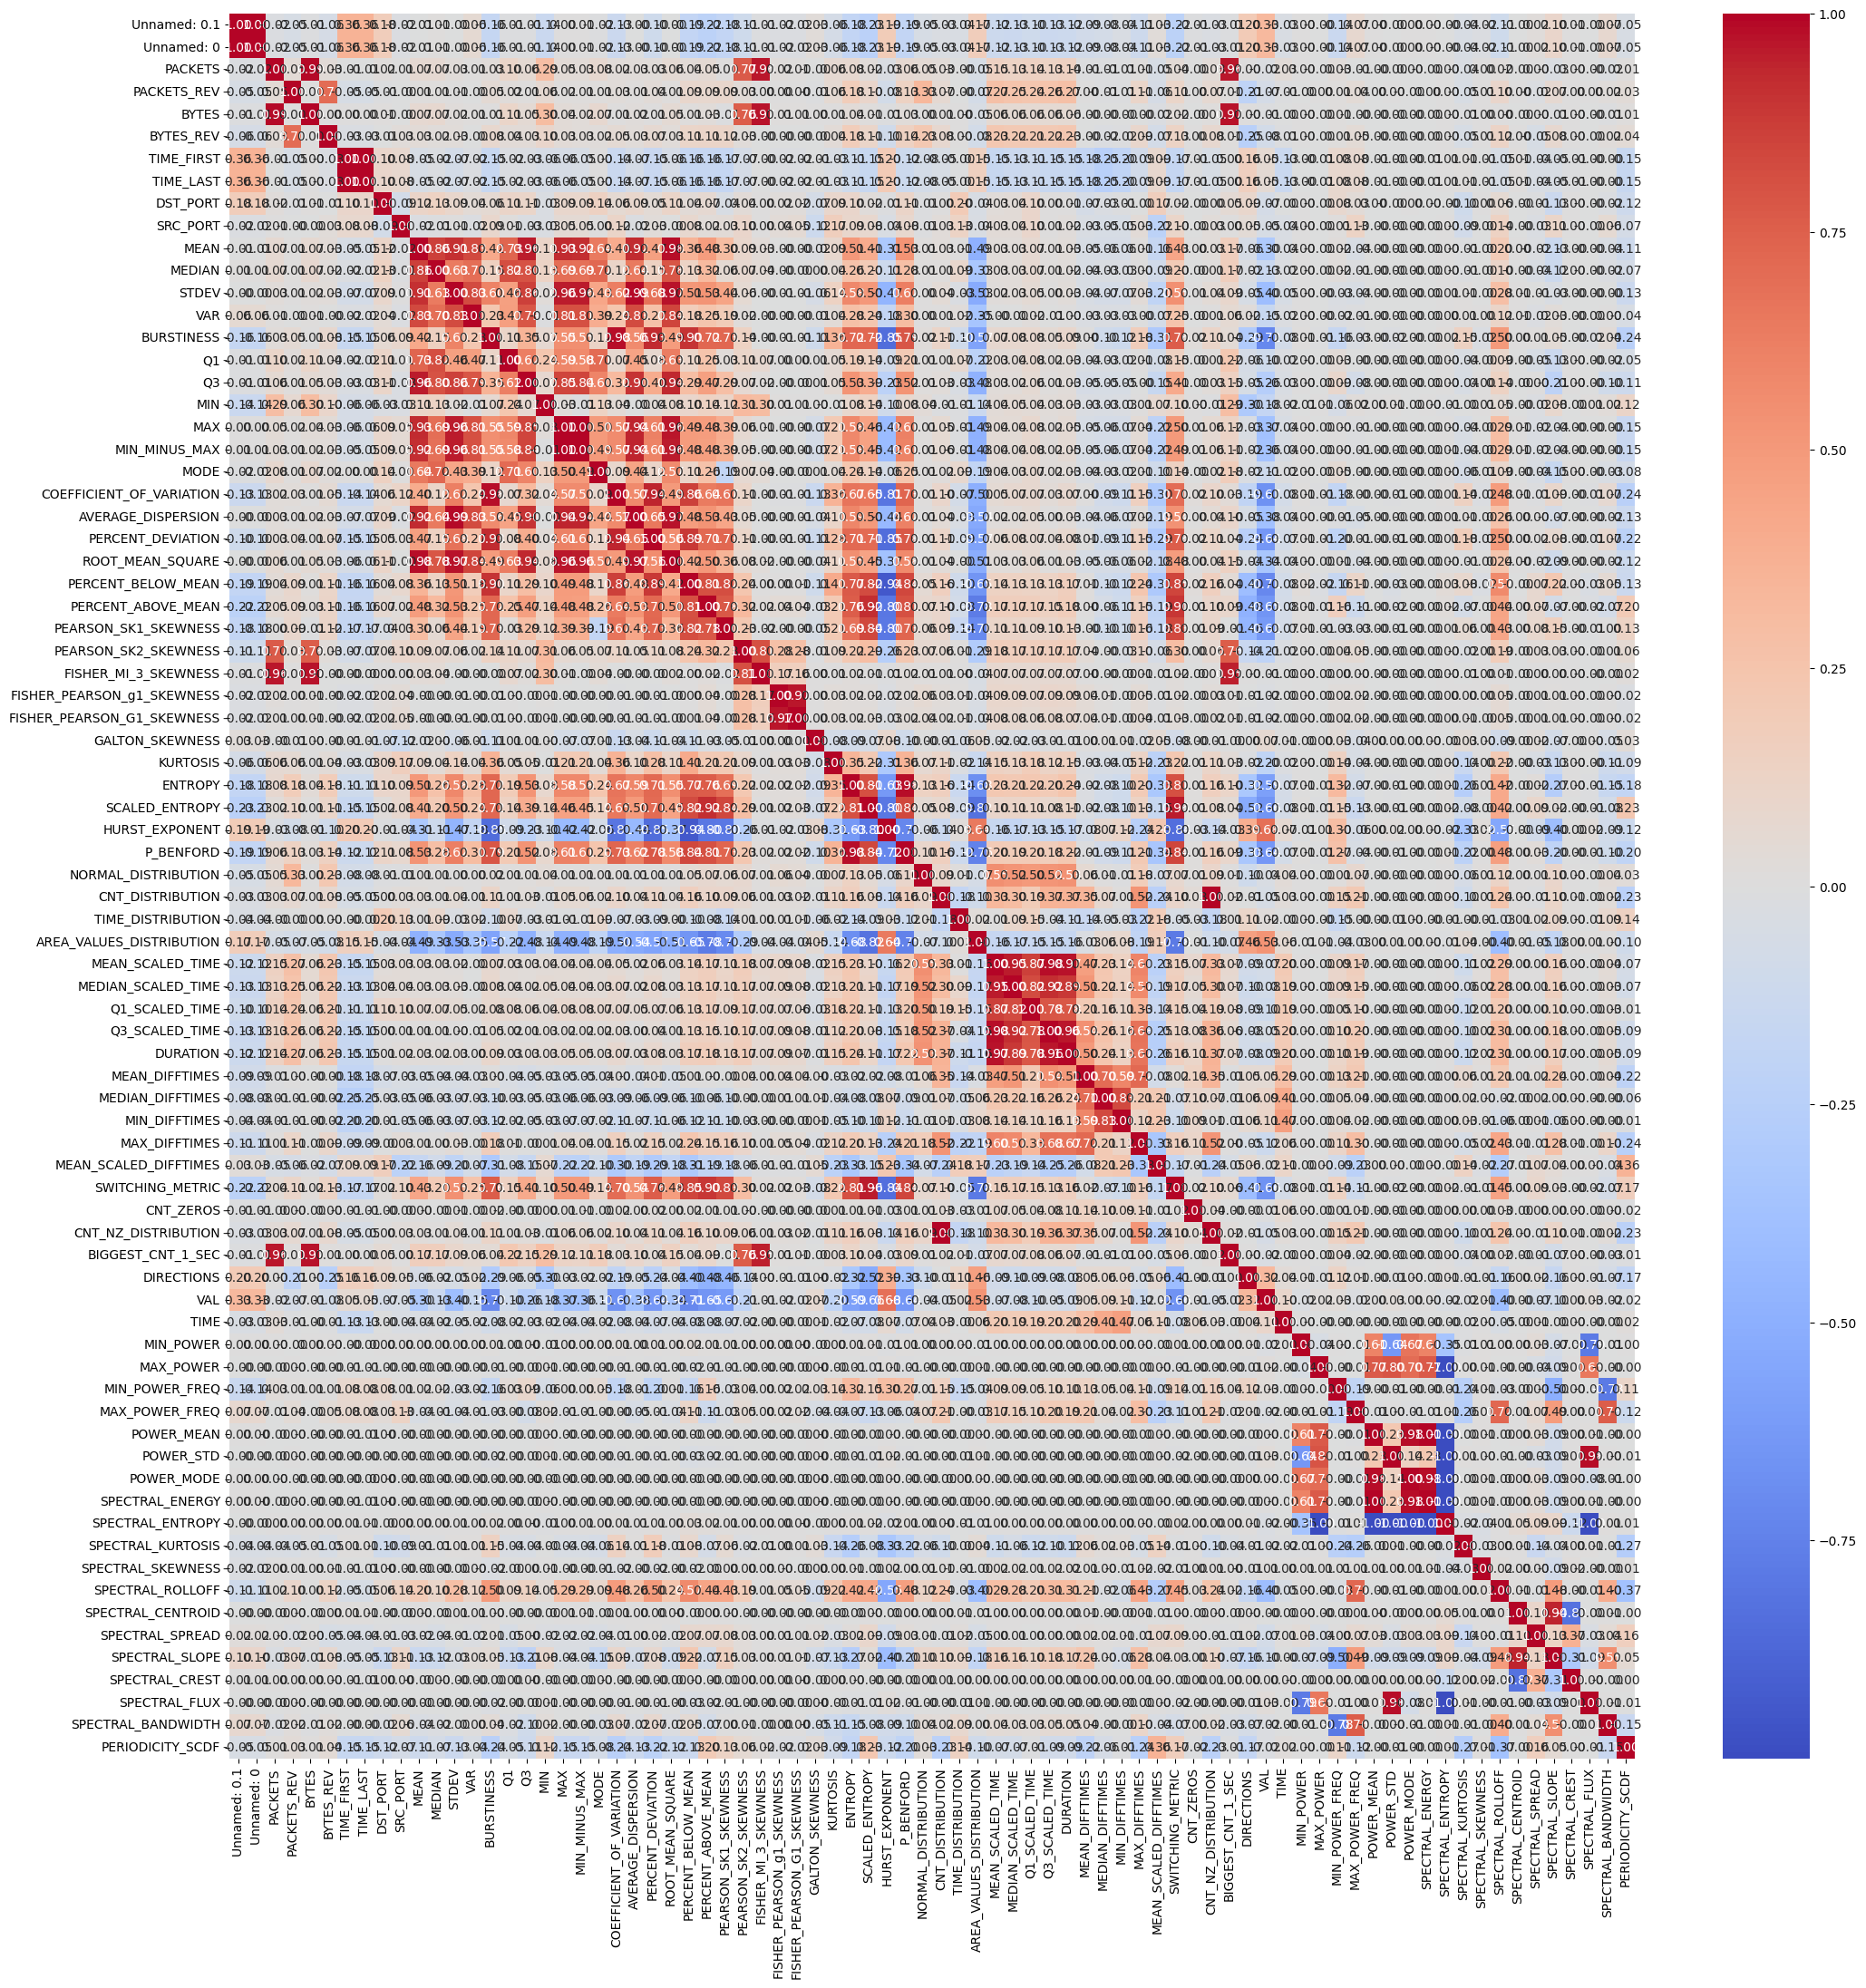

In [79]:
plt.figure(figsize=(25, 25))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.show()

In [80]:
high_corr_threshold = 0.8
high_corr_pairs = correlation_matrix.unstack().sort_values(kind="quicksort")
high_corr_pairs = high_corr_pairs[(abs(high_corr_pairs) > high_corr_threshold) & (abs(high_corr_pairs) < 1)]
high_corr_pairs


SPECTRAL_FLUX        SPECTRAL_ENTROPY   -0.999924
SPECTRAL_ENTROPY     SPECTRAL_FLUX      -0.999924
MAX_POWER            SPECTRAL_ENTROPY   -0.999924
SPECTRAL_ENTROPY     MAX_POWER          -0.999924
POWER_MODE           SPECTRAL_ENTROPY   -0.999924
                                           ...   
CNT_NZ_DISTRIBUTION  CNT_DISTRIBUTION    0.999840
TIME_FIRST           TIME_LAST           1.000000
TIME_LAST            TIME_FIRST          1.000000
SPECTRAL_ENERGY      POWER_MEAN          1.000000
POWER_MEAN           SPECTRAL_ENERGY     1.000000
Length: 178, dtype: float64

Displaying unique pairs of highly correlated features 

In [81]:
high_corr_pairs_df = high_corr_pairs.reset_index()
high_corr_pairs_df.columns = ['Feature1', 'Feature2', 'Correlation']

unique_high_corr_pairs = high_corr_pairs_df[high_corr_pairs_df['Feature1'] < high_corr_pairs_df['Feature2']]
unique_high_corr_pairs


,Feature1,Feature2,Correlation
1,SPECTRAL_ENTROPY,SPECTRAL_FLUX,-0.999924
2,MAX_POWER,SPECTRAL_ENTROPY,-0.999924
4,POWER_MODE,SPECTRAL_ENTROPY,-0.999924
6,POWER_STD,SPECTRAL_ENTROPY,-0.999921
9,POWER_MEAN,SPECTRAL_ENTROPY,-0.999871
...,...,...,...
168,AVERAGE_DISPERSION,STDEV,0.991043
170,MAX,MIN_MINUS_MAX,0.999137
172,CNT_DISTRIBUTION,CNT_NZ_DISTRIBUTION,0.999840
174,TIME_FIRST,TIME_LAST,1.000000


Checking missing values

In [82]:
missing_values = raw_data.isnull().sum()
missing_columns = missing_values[missing_values > 0]
print(missing_columns)

NORMAL_DISTRIBUTION            104
TIME_DISTRIBUTION             3193
AREA_VALUES_DISTRIBUTION        14
MEAN_DIFFTIMES                3193
MEDIAN_DIFFTIMES              3193
MIN_DIFFTIMES                 3193
MAX_DIFFTIMES                 3193
MEAN_SCALED_DIFFTIMES         3195
MIN_POWER                   133519
MAX_POWER                   133519
MIN_POWER_FREQ              133519
MAX_POWER_FREQ              133519
POWER_MEAN                  133519
POWER_STD                   133519
SPECTRAL_ENERGY             133519
SPECTRAL_ENTROPY            148954
SPECTRAL_KURTOSIS           133519
SPECTRAL_SKEWNESS           133519
SPECTRAL_CENTROID           137306
SPECTRAL_SPREAD             140581
SPECTRAL_SLOPE              150540
SPECTRAL_CREST              133519
SPECTRAL_FLUX               133519
PERIODICITY_SCDF            133519
dtype: int64


In [83]:
missing_percentage = raw_data.isnull().mean() * 100
missing_percentage_sorted = missing_percentage[missing_percentage > 0].sort_values(ascending=False)
print(missing_percentage_sorted)


SPECTRAL_SLOPE              85.224185
SPECTRAL_ENTROPY            84.326313
SPECTRAL_SPREAD             79.586164
SPECTRAL_CENTROID           77.732111
POWER_MEAN                  75.588202
POWER_STD                   75.588202
SPECTRAL_FLUX               75.588202
SPECTRAL_CREST              75.588202
SPECTRAL_SKEWNESS           75.588202
SPECTRAL_KURTOSIS           75.588202
SPECTRAL_ENERGY             75.588202
PERIODICITY_SCDF            75.588202
MAX_POWER_FREQ              75.588202
MIN_POWER_FREQ              75.588202
MAX_POWER                   75.588202
MIN_POWER                   75.588202
MEAN_SCALED_DIFFTIMES        1.808764
TIME_DISTRIBUTION            1.807631
MAX_DIFFTIMES                1.807631
MIN_DIFFTIMES                1.807631
MEDIAN_DIFFTIMES             1.807631
MEAN_DIFFTIMES               1.807631
NORMAL_DISTRIBUTION          0.058877
AREA_VALUES_DISTRIBUTION     0.007926
dtype: float64


It is clear we will have to get rid of the columns with over 75% nulls.

Missing value distribution

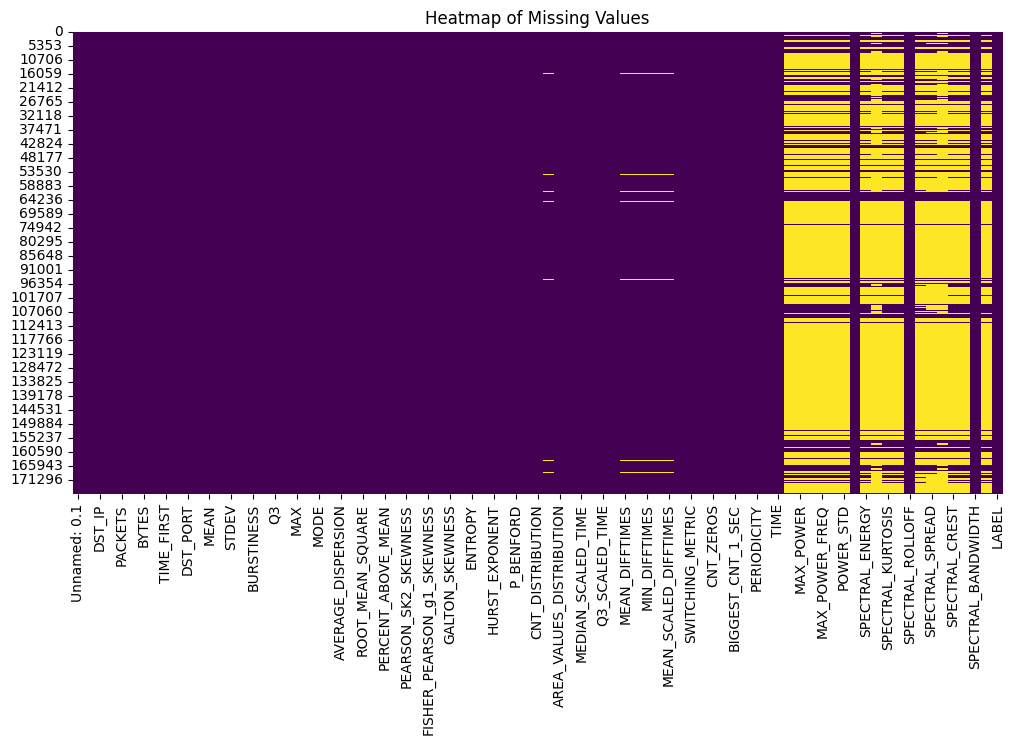

In [84]:
plt.figure(figsize=(12, 6))
sns.heatmap(raw_data.isnull(), cbar=False, cmap='viridis')
plt.title('Heatmap of Missing Values')
plt.show()

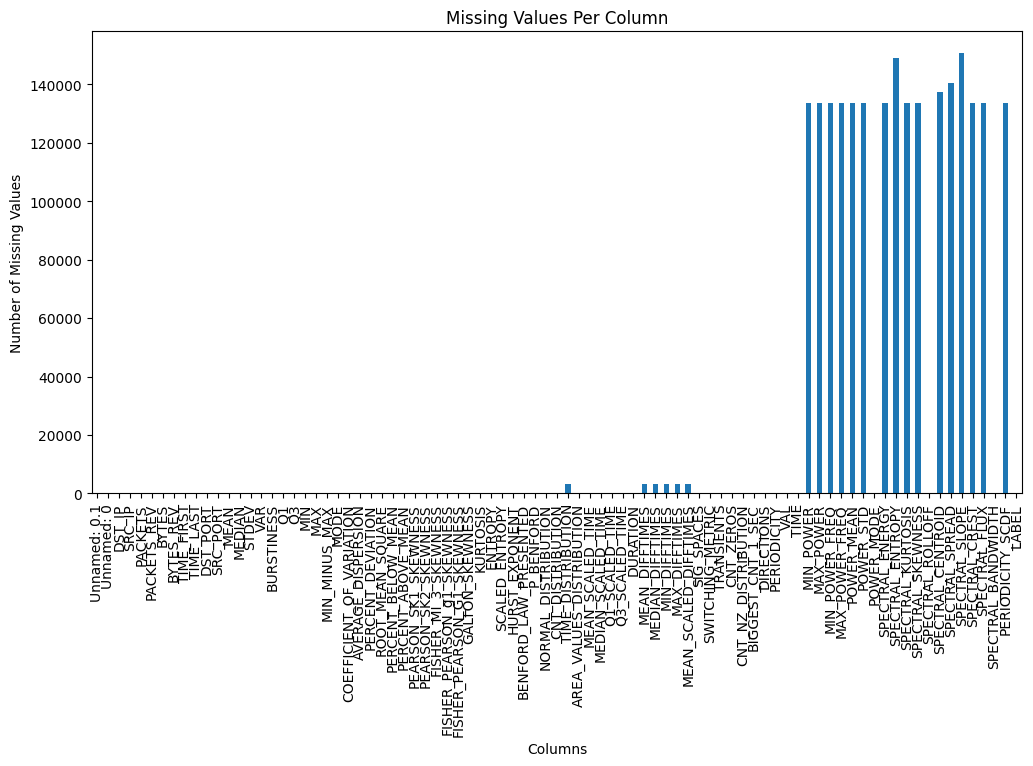

In [85]:
plt.figure(figsize=(12, 6))
missing_values.plot(kind='bar')
plt.title('Missing Values Per Column')
plt.ylabel('Number of Missing Values')
plt.xlabel('Columns')
plt.show()

## Outlier detection

In [86]:
outlier_detector = CustomOutlierDetector(raw_data)

num_cols = raw_data.describe().columns

for var in num_cols:
    outliers = outlier_detector.detect_outliers_iqr(var)

print("Outliers identified using the IQR method:")
print(outliers[num_cols])

Outliers identified using the IQR method:
Empty DataFrame
Columns: [Unnamed: 0.1, Unnamed: 0, PACKETS, PACKETS_REV, BYTES, BYTES_REV, TIME_FIRST, TIME_LAST, DST_PORT, SRC_PORT, MEAN, MEDIAN, STDEV, VAR, BURSTINESS, Q1, Q3, MIN, MAX, MIN_MINUS_MAX, MODE, COEFFICIENT_OF_VARIATION, AVERAGE_DISPERSION, PERCENT_DEVIATION, ROOT_MEAN_SQUARE, PERCENT_BELOW_MEAN, PERCENT_ABOVE_MEAN, PEARSON_SK1_SKEWNESS, PEARSON_SK2_SKEWNESS, FISHER_MI_3_SKEWNESS, FISHER_PEARSON_g1_SKEWNESS, FISHER_PEARSON_G1_SKEWNESS, GALTON_SKEWNESS, KURTOSIS, ENTROPY, SCALED_ENTROPY, HURST_EXPONENT, P_BENFORD, NORMAL_DISTRIBUTION, CNT_DISTRIBUTION, TIME_DISTRIBUTION, AREA_VALUES_DISTRIBUTION, MEAN_SCALED_TIME, MEDIAN_SCALED_TIME, Q1_SCALED_TIME, Q3_SCALED_TIME, DURATION, MEAN_DIFFTIMES, MEDIAN_DIFFTIMES, MIN_DIFFTIMES, MAX_DIFFTIMES, MEAN_SCALED_DIFFTIMES, SWITCHING_METRIC, CNT_ZEROS, CNT_NZ_DISTRIBUTION, BIGGEST_CNT_1_SEC, DIRECTIONS, VAL, TIME, MIN_POWER, MAX_POWER, MIN_POWER_FREQ, MAX_POWER_FREQ, POWER_MEAN, POWER_STD, PO

In [87]:
columns_to_summarize = ['NORMAL_DISTRIBUTION', 'TIME_DISTRIBUTION', 'AREA_VALUES_DISTRIBUTION', 'MEAN_DIFFTIMES', 'MEDIAN_DIFFTIMES', 'MIN_DIFFTIMES', 'MAX_DIFFTIMES', 'MEAN_SCALED_DIFFTIMES','MIN_POWER', 'MAX_POWER', 'MIN_POWER_FREQ', 'MAX_POWER_FREQ', 'POWER_MEAN', 'POWER_STD', 'SPECTRAL_ENERGY', 'SPECTRAL_ENTROPY', 'SPECTRAL_KURTOSIS', 'SPECTRAL_SKEWNESS', 'SPECTRAL_CENTROID', 'SPECTRAL_SPREAD', 'SPECTRAL_SLOPE', 'SPECTRAL_CREST', 'SPECTRAL_FLUX', 'PERIODICITY_SCDF']

for col in columns_to_summarize:
    summary_stats = raw_data[col].dropna().describe()
    print(f'Summary statistics for {col}:\n{summary_stats}\n')


Summary statistics for NORMAL_DISTRIBUTION:
count    176536.000000
mean          0.001644
std           0.031209
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           0.990000
Name: NORMAL_DISTRIBUTION, dtype: float64

Summary statistics for TIME_DISTRIBUTION:
count    173447.000000
mean          0.472625
std           0.083787
min           0.000000
25%           0.444428
50%           0.494112
75%           0.500000
max           0.968329
Name: TIME_DISTRIBUTION, dtype: float64

Summary statistics for AREA_VALUES_DISTRIBUTION:
count    176626.000000
mean          0.844037
std           0.076354
min           0.092742
25%           0.875000
50%           0.875000
75%           0.875000
max           0.949937
Name: AREA_VALUES_DISTRIBUTION, dtype: float64

Summary statistics for MEAN_DIFFTIMES:
count    173447.000000
mean          1.394015
std           2.765506
min           0.000000
25%           0.196598
50%           0.580722
75% 

In [88]:
boolean_columns = raw_data.select_dtypes(include=['bool']).columns
print(f"Boolean columns: {boolean_columns}")

Boolean columns: Index(['BENFORD_LAW_PRESENTED', 'SIG_SPACES', 'TRANSIENTS', 'PERIODICITY'], dtype='object')


In some columns, a significant portion of the data is missing (more, than 75%) and imputation might not be effective, so we will drop those features, because we do not want to introduce bias.

In [89]:
columns_to_drop = ['Unnamed: 0', 'Unnamed: 0.1', 'SPECTRAL_SLOPE', 'SPECTRAL_ENTROPY', 'SPECTRAL_SPREAD', 'SPECTRAL_CENTROID', 'SPECTRAL_ENERGY', 'MAX_POWER_FREQ', 'MIN_POWER', 'MIN_POWER_FREQ', 'MAX_POWER', 'SPECTRAL_KURTOSIS', 'POWER_STD', 'POWER_MEAN', 'SPECTRAL_SKEWNESS', 'SPECTRAL_FLUX', 'SPECTRAL_CREST', 'PERIODICITY_SCDF', "BENFORD_LAW_PRESENTED", "SIG_SPACES"]


In [90]:
binary_columns = ["TRANSIENTS", "PERIODICITY"]

In [91]:
pipeline = create_pipeline(drop_columns=columns_to_drop, binary_columns=binary_columns)


In [92]:
X = raw_data.drop(columns=["LABEL"])
y = raw_data["LABEL"]

In [93]:
X_transformed = pipeline.fit_transform(X)
X_transformed

array([[ 1.69223398,  0.23005255, -0.50605177, ...,  0.15406296,
        -0.14840249, -0.28347489],
       [ 0.33083579,  0.55485413, -0.44338457, ..., -0.05454168,
         0.0652464 ,  0.53045594],
       [ 0.59279473,  0.48490115, -0.48788823, ...,  0.12067799,
         0.10956537,  0.39408415],
       ...,
       [-0.59031324, -0.38181478,  0.11406408, ..., -0.06293663,
         0.00617587, -0.04214929],
       [-0.57459356, -0.6191457 ,  0.0742251 , ..., -0.09061526,
        -0.01479096, -0.04500138],
       [-0.4913422 , -0.53875888,  0.19576435, ..., -0.08755846,
        -0.04031292,  0.01169987]])

In [94]:
ordinal_encoder = OrdinalEncoder()
y_transformed = ordinal_encoder.fit_transform(y.values.reshape(-1, 1))

In [95]:
label = ['clear', 'neris', 'donbot', 'fast_flux', 'qvod', 'rbot']

## Handling class imbalance (with SMOTE)

In [96]:
resample = SMOTE(sampling_strategy='auto', random_state=42)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Dictionary to store resampled data for each fold
resampled_data = {}

for i, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    X_train, X_val = X_transformed[train_idx], X_transformed[val_idx]
    y_train, y_val = y_transformed[train_idx], y_transformed[val_idx]
    X_res, y_res = resample.fit_resample(X_train, y_train)
    resampled_data[i] = (X_res, y_res, X_val, y_val)  # Store resampled and validation sets


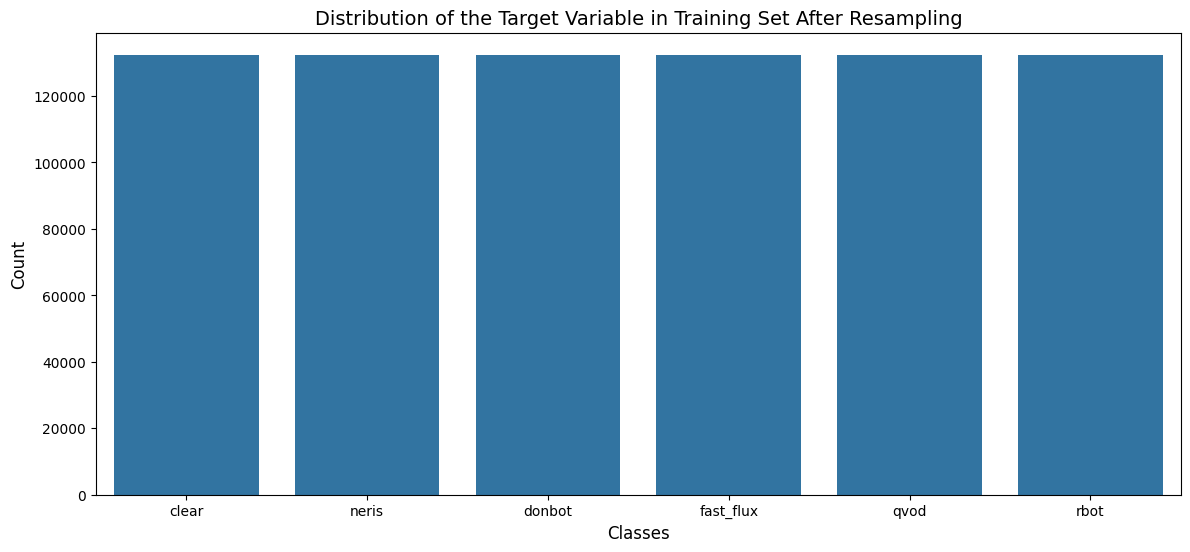

In [97]:
data_array = resampled_data[0][1].flatten()
unique, counts = np.unique(data_array, return_counts=True)
index_counts = dict(zip(unique.astype(int), counts))
mapped_counts = [index_counts.get(i, 0) for i in range(len(label))]

plt.figure(figsize=(14, 6))
sns.barplot(x=label, y=mapped_counts)
plt.title('Distribution of the Target Variable in Training Set After Resampling', fontsize=14)
plt.xlabel('Classes', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks()
plt.show()

In [98]:
models = [
    LogisticRegression(max_iter=1000),
    RandomForestClassifier(n_estimators=100),
    SVC(kernel='linear'),
    KNeighborsClassifier(n_neighbors=5),
    GaussianNB()]

In [100]:
evaluator = CustomEvaluator(model=None, k_count=5)

all_metrics = {}
all_conf_matrices = {}

for model in models:
    print(f"Evaluating {model.__class__.__name__}...")
    evaluator.model = model
    metrics_df, conf_matrix = evaluator.evaluate(resampled_data)
    
    # Store the results
    all_metrics[model.__class__.__name__] = metrics_df
    all_conf_matrices[model.__class__.__name__] = conf_matrix

    print(f"\nMetrics for {model.__class__.__name__}:")
    print(metrics_df)
    
    print(f"\nConfusion Matrix for {model.__class__.__name__}:")
    print(conf_matrix)


Evaluating LogisticRegression...

Metrics for LogisticRegression:
           Precision    Recall  F1-score  Overall Accuracy
clear       0.999442  0.984659  0.991995          0.984828
donbot      0.184170  0.826667  0.293268          0.984828
fast_flux   0.987255  0.991299  0.989258          0.984828
neris       0.882713  0.987366  0.932067          0.984828
qvod        0.469273  0.968603  0.626269          0.984828
rbot        0.036792  0.854545  0.070501          0.984828
Overall     0.984828  0.984828  0.984828          0.984828

Confusion Matrix for LogisticRegression:
[[163033     85     47    831    338   1239]
 [     1     22      2      0      2      0]
 [    13     17   4329      0      1      7]
 [    72      0      1   6252      0      7]
 [     1      5      3      0    277      0]
 [     4      0      3      1      0     47]]
Evaluating RandomForestClassifier...

Metrics for RandomForestClassifier:
           Precision    Recall  F1-score  Overall Accuracy
clear       0.99

In [101]:
print(all_metrics)
print("Confusion Matrix:")
print(all_conf_matrices)

{'LogisticRegression':            Precision    Recall  F1-score  Overall Accuracy
clear       0.999442  0.984659  0.991995          0.984828
donbot      0.184170  0.826667  0.293268          0.984828
fast_flux   0.987255  0.991299  0.989258          0.984828
neris       0.882713  0.987366  0.932067          0.984828
qvod        0.469273  0.968603  0.626269          0.984828
rbot        0.036792  0.854545  0.070501          0.984828
Overall     0.984828  0.984828  0.984828          0.984828, 'RandomForestClassifier':            Precision    Recall  F1-score  Overall Accuracy
clear       0.999481  0.999632  0.999556          0.999038
donbot      0.966667  0.753333  0.825152          0.999038
fast_flux   0.996107  0.995878  0.995991          0.999038
neris       0.990393  0.992419  0.991401          0.999038
qvod        0.988601  0.933696  0.960024          0.999038
rbot        0.950000  0.690909  0.797427          0.999038
Overall     0.999038  0.999038  0.999038          0.999038, 'SVC'